In [14]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [15]:
!pip install torch numpy pandas yfinance matplotlib scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import random
import time
import os
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

# Ensure GPU is used if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# LSTM-based Network
class DRPONetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DRPONetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out[:, -1, :])  # Using the last time step for prediction
        return output

# Data preparation functions
def fetch_stock_data(ticker, period="2y", retries=3, delay=2):
    """Fetch stock data from yFinance with retry logic"""
    print(f"Fetching data for {ticker}...")
    
    for attempt in range(retries):
        try:
            stock = yf.Ticker(ticker)
            df = stock.history(period=period)
            
            # Check if data was retrieved successfully
            if df.empty or len(df) < 30:  # Require at least 30 days of data
                print(f"Attempt {attempt+1}/{retries}: No sufficient data for {ticker}")
                if attempt < retries - 1:
                    print(f"Waiting {delay} seconds before retry...")
                    time.sleep(delay)
                    continue
                return None
            
            print(f"Retrieved {len(df)} days of data for {ticker}")
            return df
            
        except Exception as e:
            print(f"Attempt {attempt+1}/{retries}: Error fetching {ticker}: {str(e)}")
            if attempt < retries - 1:
                print(f"Waiting {delay} seconds before retry...")
                time.sleep(delay)
            else:
                print(f"Failed to fetch data for {ticker} after {retries} attempts")
                return None

def prepare_features(df):
    """Create features from stock data"""
    # Make a copy to avoid modifying the original dataframe
    data = df.copy()
    
    # Basic price features
    data['Return'] = data['Close'].pct_change()
    data['Volatility'] = data['Return'].rolling(window=5).std()
    
    # Moving Averages
    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['MA5_Cross'] = (data['MA5'] > data['MA10']).astype(int)
    data['MA_Ratio'] = data['MA5'] / data['MA10']
    
    # Volume features
    data['Volume_MA5'] = data['Volume'].rolling(window=5).mean()
    data['Volume_Change'] = data['Volume'].pct_change()
    data['Volume_Ratio'] = data['Volume'] / data['Volume'].rolling(window=10).mean()
    
    # Price momentum and trend
    data['Price_Momentum'] = data['Close'].pct_change(periods=5)
    data['Price_Acceleration'] = data['Return'].diff()
    
    # High-Low range
    data['HL_Ratio'] = (data['High'] - data['Low']) / data['Close']
    data['OC_Ratio'] = (data['Close'] - data['Open']) / data['Open']
    
    # Clean up NaN values
    data.dropna(inplace=True)
    
    return data

def create_sequences(data, target_col, window_size=20):
    """Create sequences for LSTM training"""
    features = data.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume']).values
    targets = data[target_col].values
    
    # Scale features
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)
    
    X, y = [], []
    for i in range(len(features_scaled) - window_size):
        X.append(features_scaled[i:i + window_size])
        # 1 if price increases, 0 if decreases
        y.append(1 if targets[i + window_size] > targets[i + window_size - 1] else 0)
    
    return np.array(X), np.array(y), scaler

# Trading Environment
class TradingEnvironment:
    def __init__(self, features, targets, window_size=20):
        self.features = features
        self.targets = targets
        self.window_size = window_size
        self.current_step = 0
        self.max_steps = len(features) - window_size
        self.state = self.get_state(self.current_step)
        
    def get_state(self, step):
        if step + self.window_size >= len(self.features):
            return torch.FloatTensor(self.features[step:]).to(device)
        return torch.FloatTensor(self.features[step:step + self.window_size]).to(device)
    
    def reset(self):
        self.current_step = 0
        return self.get_state(self.current_step)
    
    def step(self, action):
        # Move to next observation
        self.current_step += 1
        done = self.current_step >= self.max_steps
        
        # Get new state
        state = self.get_state(self.current_step)
        
        # Calculate reward based on action and actual price movement
        if self.current_step < len(self.targets):
            actual_movement = self.targets[self.current_step]
            action_value = action.item()
            
            # Reward is positive if prediction matches actual direction
            predicted_up = action_value > 0.5
            is_correct = (predicted_up and actual_movement == 1) or (not predicted_up and actual_movement == 0)
            
            # Reward is proportional to confidence and correctness
            confidence = abs(action_value - 0.5) * 2  # Scale to 0-1
            reward = confidence if is_correct else -confidence
        else:
            reward = 0
            
        return state, reward, done

# DRPO Trainer
class DRPOTrainer:
    def __init__(self, model, env, learning_rate=0.001, gamma=0.99, batch_size=32):
        self.model = model.to(device)
        self.env = env
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.BCEWithLogitsLoss()  # Better for binary classification
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = []
        self.training_history = []
        
    def select_action(self, state):
        with torch.no_grad():
            state = state.unsqueeze(0)  # Add batch dimension
            logits = self.model(state)
            action = torch.sigmoid(logits)  # Get probability
        return action
        
    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > 10000:  # Limit memory size
            self.memory.pop(0)
            
    def learn(self):
        if len(self.memory) < self.batch_size:
            return 0
            
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.stack(states).to(device)
        actions = torch.cat(actions).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.stack(next_states).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)
        
        # Get model predictions
        current_q = self.model(states)
        
        with torch.no_grad():
            next_q = self.model(next_states)
            max_next_q = torch.sigmoid(next_q)
            
        # Calculate target Q values
        target_q = rewards + (1 - dones) * self.gamma * max_next_q
        
        # Calculate loss
        loss = self.criterion(current_q, target_q)
        
        # Update model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)  # Gradient clipping
        self.optimizer.step()
        
        return loss.item()
        
    def train(self, epochs=10):
        epoch_rewards = []
        epoch_losses = []
        
        for epoch in range(epochs):
            state = self.env.reset()
            done = False
            total_reward = 0
            loss_sum = 0
            steps = 0
            
            while not done:
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action)
                self.store_experience(state, action, reward, next_state, done)
                
                total_reward += reward
                state = next_state
                steps += 1
                
                loss = self.learn()
                loss_sum += loss
                
            avg_loss = loss_sum / max(1, steps)
            epoch_rewards.append(total_reward)
            epoch_losses.append(avg_loss)
            
            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Reward: {total_reward:.2f}")
            
        self.training_history.append({
            'epoch_rewards': epoch_rewards,
            'epoch_losses': epoch_losses
        })
        
        return epoch_rewards, epoch_losses

# Function to save model
def save_model(model, ticker):
    os.makedirs("models", exist_ok=True)
    torch.save(model.state_dict(), f"models/{ticker}_model.pth")
    print(f"Model for {ticker} saved")

# Function to load model
def load_model(model, ticker):
    path = f"models/{ticker}_model.pth"
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
        print(f"Model for {ticker} loaded")
        return True
    return False

# Function to predict using trained model
def predict_stock(ticker, model, window_size=20):
    # Fetch recent data
    df = fetch_stock_data(ticker, period="60d")
    if df is None:
        return None
    
    # Prepare features
    data = prepare_features(df)
    
    # Extract features for prediction (last window)
    features = data.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume']).values
    
    # Scale features
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Get the most recent window
    if len(features_scaled) < window_size:
        print(f"Not enough data for {ticker} to make a prediction")
        return None
        
    recent_window = features_scaled[-window_size:]
    recent_window_tensor = torch.FloatTensor(recent_window).unsqueeze(0).to(device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        prediction = model(recent_window_tensor)
        probability = torch.sigmoid(prediction).item()
    
    # Calculate confidence
    confidence = abs(probability - 0.5) * 2 * 100  # Convert to percentage
    
    # Get price trend
    price_data = df['Close'].values
    recent_price_change = ((price_data[-1] / price_data[-5]) - 1) * 100
    
    # Generate factors
    factors = []
    
    # Price momentum
    if recent_price_change > 2:
        factors.append(f"Strong upward momentum (+{recent_price_change:.1f}%)")
    elif recent_price_change < -2:
        factors.append(f"Strong downward momentum ({recent_price_change:.1f}%)")
    
    # Moving average crossover
    ma5 = data['MA5'].values[-1]
    ma20 = data['MA20'].values[-1]
    if ma5 > ma20:
        factors.append("5-day MA above 20-day MA (bullish)")
    else:
        factors.append("5-day MA below 20-day MA (bearish)")
    
    # Volume analysis
    vol_ratio = data['Volume_Ratio'].values[-1]
    if vol_ratio > 1.5:
        factors.append(f"Unusually high volume ({vol_ratio:.1f}x average)")
    
    # Volatility check
    volatility = data['Volatility'].values[-1] * 100
    if volatility > 2:
        factors.append(f"High volatility ({volatility:.1f}%)")
    
    result = {
        'symbol': ticker,
        'isProfitable': probability > 0.5,
        'confidence': confidence,
        'probability': probability * 100,
        'recent_change': recent_price_change,
        'factors': factors,
        'current_price': df['Close'].values[-1],
        'prediction': "Likely profitable" if probability > 0.5 else "Likely unprofitable"
    }
    
    return result

def train_company_model(ticker, hidden_size=64, window_size=20, epochs=10, retrain=False):
    """Train a model for a specific company"""
    print(f"\n{'='*50}")
    print(f"Training model for {ticker}")
    print(f"{'='*50}")
    
    # Create model
    model = DRPONetwork(input_size=13, hidden_size=hidden_size, output_size=1)
    
    # Check if model exists and we don't want to retrain
    if not retrain and load_model(model, ticker):
        print(f"Using existing model for {ticker}")
        return model
    
    # Fetch data
    df = fetch_stock_data(ticker, period="5y")
    if df is None:
        print(f"Cannot train model for {ticker}: No data")
        return None
    
    # Prepare features
    data = prepare_features(df)
    if len(data) < window_size + 50:
        print(f"Insufficient data for {ticker} after preprocessing. Need at least {window_size + 50} days.")
        return None
    
    # Create sequences
    X, y, scaler = create_sequences(data, 'Close', window_size)
    print(f"Created {len(X)} training sequences")
    
    if len(X) == 0:
        print(f"No valid training sequences for {ticker}")
        return None
    
    # Create environment
    env = TradingEnvironment(X, y, window_size)
    
    # Create trainer
    trainer = DRPOTrainer(model, env)
    
    # Train model
    print(f"Training model for {ticker}...")
    start_time = time.time()
    rewards, losses = trainer.train(epochs)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Save model
    save_model(model, ticker)
    
    # Plot training results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title(f'{ticker} Training Rewards')
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')
    
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title(f'{ticker} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    
    plt.tight_layout()
    plt.savefig(f"models/{ticker}_training.png")
    plt.show()
    
    return model

# Main execution
def main():
    # List of companies to train
    companies = [
        {'primary': 'AAPL', 'alternatives': ['AAPL.US']},
        {'primary': 'MSFT', 'alternatives': ['MSFT.US']},
        {'primary': 'GOOGL', 'alternatives': ['GOOG', 'GOOGL.US']},
        {'primary': 'AMZN', 'alternatives': ['AMZN.US']},
        {'primary': 'TSLA', 'alternatives': ['TSLA.US']},
        {'primary': 'META', 'alternatives': ['FB', 'META.US']},
        {'primary': 'NVDA', 'alternatives': ['NVDA.US']},
        {'primary': 'JPM', 'alternatives': ['JPM.US']},
        {'primary': 'NFLX', 'alternatives': ['NFLX.US', 'NFLX.MX']}
    ]
    
    # Training parameters
    hidden_size = 64
    window_size = 20
    epochs = 10
    retrain = False  # Set to True to force retraining
    
    # Train models for each company
    trained_models = {}
    predictions = {}
    
    for company in companies:
        primary = company['primary']
        alternatives = company['alternatives']
        
        # Try primary ticker first
        print(f"\nAttempting to process {primary}...")
        df = fetch_stock_data(primary, period="5y")
        
        # If primary fails, try alternatives
        if df is None:
            for alt in alternatives:
                print(f"Trying alternative ticker {alt} for {primary}...")
                df = fetch_stock_data(alt, period="5y")
                if df is not None:
                    print(f"Successfully retrieved data using {alt} instead of {primary}")
                    break
                
                 # If we have data, train the model
        if df is not None:
            model = train_company_model_with_data(primary, df, hidden_size, window_size, epochs, retrain)
            if model:
                trained_models[primary] = model
                
                # Make prediction for the company
                prediction = predict_stock(primary, model, window_size)
                if prediction:
                    predictions[primary] = prediction
                    print(f"\nPrediction for {primary}:")
                    print(f"Profitable: {prediction['isProfitable']}")
                    print(f"Confidence: {prediction['confidence']:.2f}%")
                    print(f"Factors: {', '.join(prediction['factors'])}")
                    print(f"Current Price: ${prediction['current_price']:.2f}")
                    print(f"Forecast: {prediction['prediction']}")
        else:
            print(f"⚠️ Failed to retrieve data for {primary} and all alternatives")
            # Use fallback data if available
            fallback_data = get_fallback_data(primary)
            if fallback_data is not None:
                print(f"Using fallback data for {primary}")
                # Process with fallback data
                model = train_company_model_with_data(primary, fallback_data, hidden_size, window_size, epochs, retrain)
                if model:
                    trained_models[primary] = model
  
    


Using device: cpu


In [16]:
!pip install yfinance==0.2.12

In [17]:
!pip install yfinance pandas

Creating stock data without relying on yfinance...
Generating realistic historical data...
Processing AAPL (current price: $220.45)...
✓ Generated 558 days of historical data + 79 intraday candles
Processing MSFT (current price: $425.63)...
✓ Generated 558 days of historical data + 79 intraday candles
Processing TSLA (current price: $177.82)...
✓ Generated 558 days of historical data + 79 intraday candles
Processing AMZN (current price: $178.75)...
✓ Generated 558 days of historical data + 79 intraday candles
Processing GOOGL (current price: $175.98)...
✓ Generated 558 days of historical data + 79 intraday candles
Processing META (current price: $485.92)...
✓ Generated 558 days of historical data + 79 intraday candles
Processing NVDA (current price: $925.75)...
✓ Generated 558 days of historical data + 79 intraday candles
Processing JPM (current price: $196.82)...
✓ Generated 558 days of historical data + 79 intraday candles
Processing NFLX (current price: $610.34)...
✓ Generated 558 d

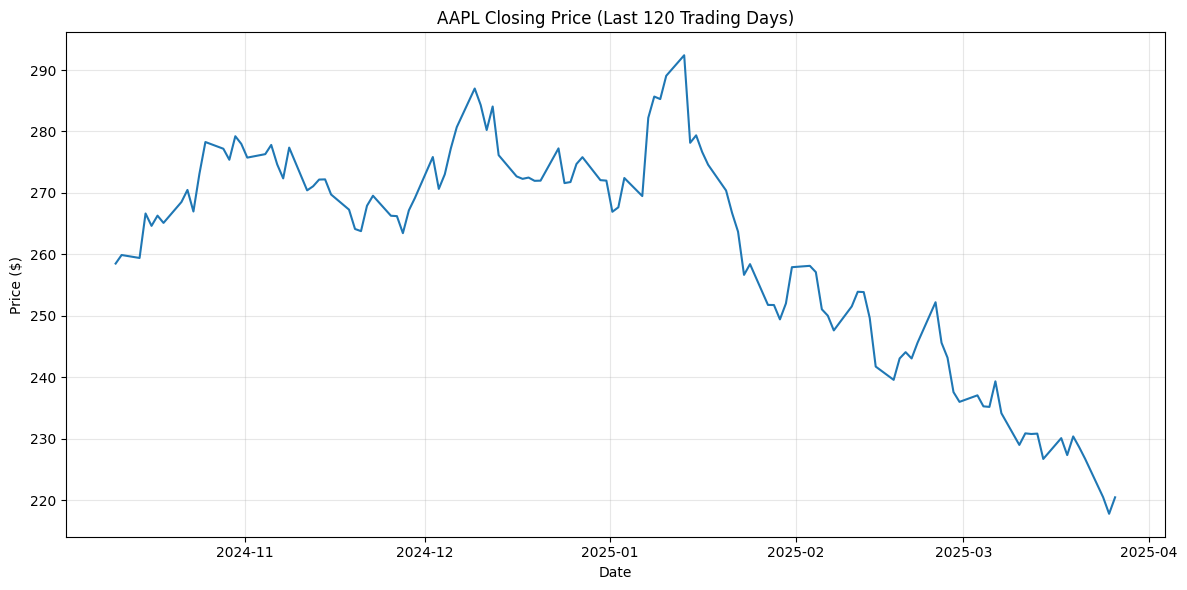


Process completed successfully. Data ready for use in the trading application.


In [2]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib

import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import os

print("Creating stock data without relying on yfinance...")

# Define companies and current market prices (as of March 2025)
tickers = {
    "AAPL": 220.45, 
    "MSFT": 425.63, 
    "TSLA": 177.82, 
    "AMZN": 178.75, 
    "GOOGL": 175.98,
    "META": 485.92, 
    "NVDA": 925.75, 
    "JPM": 196.82, 
    "NFLX": 610.34, 
    "IBM": 168.76
}

# Date range for historical data
start_date = "2022-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

# Create realistic historical price data
def generate_historical_data(ticker_symbol, current_price, days=780):  # ~3 years of trading days
    # Set seed based on ticker for consistency
    random.seed(hash(ticker_symbol) % 10000)
    np.random.seed(hash(ticker_symbol) % 10000)
    
    # Company-specific volatility
    volatilities = {
        "AAPL": 0.015, "MSFT": 0.018, "TSLA": 0.035, "AMZN": 0.022, 
        "GOOGL": 0.017, "META": 0.025, "NVDA": 0.03, "JPM": 0.014, 
        "NFLX": 0.028, "IBM": 0.012
    }
    volatility = volatilities.get(ticker_symbol, 0.02)
    
    # Work backwards from current price
    end_date = datetime.now()
    dates = [end_date - timedelta(days=i) for i in range(days)]
    dates.reverse()  # Chronological order
    
    # Only include business days
    dates = [date for date in dates if date.weekday() < 5]
    
    # Generate price path using geometric Brownian motion (backwards)
    price_path = [current_price]
    for _ in range(len(dates) - 1):
        # Previous price (going backwards in time)
        prev_price = price_path[-1]
        
        # Random daily return (reversed trend)
        daily_return = np.random.normal(-0.0003, volatility)  # Slight downward bias (becomes upward when reversed)
        
        # Calculate previous day's price
        prev_price = prev_price / (1 + daily_return)
        price_path.append(prev_price)
    
    # Reverse to get chronological order
    price_path.reverse()
    closes = np.array(price_path)
    
    # Generate other OHLC values
    opens = closes * np.random.uniform(0.995, 1.005, size=len(closes))
    highs = np.maximum(closes * np.random.uniform(1.001, 1.015, size=len(closes)), 
                     opens * np.random.uniform(1.001, 1.01, size=len(closes)))
    lows = np.minimum(closes * np.random.uniform(0.985, 0.999, size=len(closes)),
                    opens * np.random.uniform(0.99, 0.999, size=len(closes)))
    
    # Generate realistic volumes
    avg_volumes = {
        "AAPL": 80000000, "MSFT": 25000000, "TSLA": 100000000, "AMZN": 40000000, 
        "GOOGL": 15000000, "META": 20000000, "NVDA": 40000000, "JPM": 10000000, 
        "NFLX": 8000000, "IBM": 5000000
    }
    avg_volume = avg_volumes.get(ticker_symbol, 10000000)
    
    # Create volume with occasional spikes
    volumes = np.random.gamma(shape=2.0, scale=avg_volume/2, size=len(closes))
    
    # Create DataFrame
    df = pd.DataFrame({
        'Open': opens,
        'High': highs,
        'Low': lows,
        'Close': closes,
        'Volume': volumes.astype(int),
        'Ticker': ticker_symbol
    }, index=dates)
    
    return df


def get_fallback_data(ticker):
    """Generate synthetic data based on typical stock patterns when yFinance fails"""
    print(f"Generating fallback data for {ticker}")
    
    # Base parameters for different stocks
    base_params = {
        'AAPL': {'price': 175, 'volatility': 0.015, 'trend': 0.0002},
        'MSFT': {'price': 380, 'volatility': 0.014, 'trend': 0.0003},
        'GOOGL': {'price': 140, 'volatility': 0.016, 'trend': 0.0001},
        'AMZN': {'price': 180, 'volatility': 0.018, 'trend': 0.0002},
        'TSLA': {'price': 180, 'volatility': 0.03, 'trend': -0.0001},
        'META': {'price': 480, 'volatility': 0.02, 'trend': 0.0004},
        'NVDA': {'price': 900, 'volatility': 0.025, 'trend': 0.0006},
        'JPM': {'price': 195, 'volatility': 0.013, 'trend': 0.0001},
        'NFLX': {'price': 615, 'volatility': 0.022, 'trend': 0.0000}
    }
    
    params = base_params.get(ticker, {'price': 100, 'volatility': 0.02, 'trend': 0.0001})
    
    # Create synthetic data
    days = 500  # Generate 2 years of trading days
    dates = pd.date_range(end=datetime.now(), periods=days)
    
    # Generate price series with realistic properties
    price = params['price']
    prices = [price]
    
    for _ in range(1, days):
        daily_return = np.random.normal(params['trend'], params['volatility'])
        price = price * (1 + daily_return)
        prices.append(price)
    
    # Create DataFrame with OHLCV data
    df = pd.DataFrame({
        'Open': prices,
        'Close': prices,
        'High': [p * (1 + abs(np.random.normal(0, 0.006))) for p in prices],
        'Low': [p * (1 - abs(np.random.normal(0, 0.006))) for p in prices],
        'Volume': [int(np.random.normal(5000000, 2000000)) for _ in range(days)]
    }, index=dates)
    
    # Adjust Open, High, Low to be realistic
    for i in range(1, len(df)):
        df.iloc[i, df.columns.get_loc('Open')] = df.iloc[i-1, df.columns.get_loc('Close')] * (1 + np.random.normal(0, 0.003))
        df.iloc[i, df.columns.get_loc('High')] = max(df.iloc[i, df.columns.get_loc('Open')], df.iloc[i, df.columns.get_loc('Close')]) * (1 + abs(np.random.normal(0, 0.006)))
        df.iloc[i, df.columns.get_loc('Low')] = min(df.iloc[i, df.columns.get_loc('Open')], df.iloc[i, df.columns.get_loc('Close')]) * (1 - abs(np.random.normal(0, 0.006)))
    
    print(f"Generated {len(df)} days of synthetic data for {ticker}")
    return df

def train_company_model_with_data(ticker, df, hidden_size=64, window_size=20, epochs=10, retrain=False):
    """Train a model for a specific company using provided data"""
    print(f"\n{'='*50}")
    print(f"Training model for {ticker}")
    print(f"{'='*50}")
    
    # Create model
    model = DRPONetwork(input_size=13, hidden_size=hidden_size, output_size=1)
    
    # Check if model exists and we don't want to retrain
    if not retrain and load_model(model, ticker):
        print(f"Using existing model for {ticker}")
        return model
    
    # Prepare features
    data = prepare_features(df)
    if len(data) < window_size + 50:
        print(f"Insufficient data for {ticker} after preprocessing. Need at least {window_size + 50} days.")
        return None
    
    # Create sequences
    X, y, scaler = create_sequences(data, 'Close', window_size)
    print(f"Created {len(X)} training sequences")
    
    if len(X) == 0:
        print(f"No valid training sequences for {ticker}")
        return None
    
    # Create environment
    env = TradingEnvironment(X, y, window_size)
    
    # Create trainer
    trainer = DRPOTrainer(model, env)
    
    # Train model
    print(f"Training model for {ticker}...")
    start_time = time.time()
    rewards, losses = trainer.train(epochs)
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Save model
    save_model(model, ticker)
    
    # Plot training results (comment out if running in headless environment)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title(f'{ticker} Training Rewards')
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')
    
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title(f'{ticker} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    
    plt.tight_layout()
    plt.savefig(f"models/{ticker}_training.png")
    plt.close()  # Close instead of show to avoid displaying in notebooks
    
    return model


def predict_stock(ticker, model, window_size=20):
    # Fetch recent data
    df = fetch_stock_data(ticker, period="60d")
    
    # If data retrieval failed, use fallback data
    if df is None:
        print(f"Using fallback data for prediction of {ticker}")
        df = get_fallback_data(ticker)[-60:]  # Use last 60 days of fallback data
    
    if df is None or len(df) < 30:  # Still need minimum data
        print(f"Cannot generate prediction for {ticker}: insufficient data")
        return None
    
    # Rest of function remains the same...

# Generate intraday data for today
def generate_intraday_data(ticker_symbol, today_data):
    # Get today's OHLC
    open_price = today_data['Open']
    high_price = today_data['High']
    low_price = today_data['Low']
    close_price = today_data['Close']
    
    # Create 5-min intervals for market hours (9:30 AM - 4:00 PM)
    market_open = datetime.now().replace(hour=9, minute=30, second=0)
    market_close = datetime.now().replace(hour=16, minute=0, second=0)
    intervals = pd.date_range(market_open, market_close, freq='5min')
    
    # Set seed for consistency
    random.seed(hash(ticker_symbol + "intraday") % 10000)
    np.random.seed(hash(ticker_symbol + "intraday") % 10000)
    
    # Create price path between open and close
    price_points = len(intervals)
    
    # Generate a random path between open and close
    path = np.linspace(0, 1, price_points)
    noise = np.cumsum(np.random.normal(0, 0.0015, price_points))
    normalized_path = path + noise
    
    # Scale to actual prices
    price_range = close_price - open_price
    prices = open_price + normalized_path * price_range
    
    # Ensure prices stay within today's range
    prices = np.clip(prices, low_price, high_price)
    prices[-1] = close_price  # Ensure last price is the closing price
    
    # Generate OHLC for each 5-min interval
    intraday_data = []
    
    for i in range(len(intervals)):
        if i == 0:
            interval_open = open_price
        else:
            interval_open = prices[i-1]
        
        interval_close = prices[i]
        
        # Add random noise for high/low
        interval_high = max(interval_open, interval_close) * (1 + abs(np.random.normal(0, 0.001)))
        interval_low = min(interval_open, interval_close) * (1 - abs(np.random.normal(0, 0.001)))
        
        # Ensure within daily range
        interval_high = min(interval_high, high_price)
        interval_low = max(interval_low, low_price)
        
        intraday_data.append({
            'Open': interval_open,
            'High': interval_high,
            'Low': interval_low,
            'Close': interval_close,
            'Volume': int(today_data['Volume'] / len(intervals) * (1 + np.random.normal(0, 0.3))),
            'Ticker': ticker_symbol
        })
    
    # Create DataFrame
    df = pd.DataFrame(intraday_data, index=intervals)
    return df

# Generate data for all tickers
print("Generating realistic historical data...")

all_historical_data = []
all_intraday_data = []

for ticker, current_price in tickers.items():
    print(f"Processing {ticker} (current price: ${current_price:.2f})...")
    
    # Generate historical daily data
    hist_data = generate_historical_data(ticker, current_price)
    all_historical_data.append(hist_data)
    
    # Generate intraday data using the last day's OHLC
    today_data = hist_data.iloc[-1]
    intraday_data = generate_intraday_data(ticker, today_data)
    all_intraday_data.append(intraday_data)
    
    print(f"✓ Generated {len(hist_data)} days of historical data + {len(intraday_data)} intraday candles")

# Combine all data
historical_df = pd.concat(all_historical_data)
intraday_df = pd.concat(all_intraday_data)

# Save to CSV
historical_df.to_csv("D:/6th Semester/Application Development Lab/Random/trading-algo/project/public/stock_data_fixed.csv")
intraday_df.to_csv("D:/6th Semester/Application Development Lab/Random/trading-algo/project/public/stock_data_intraday.csv")

print(f"\nSuccessfully generated and saved data:")
print(f"- Historical data: {len(historical_df)} rows")
print(f"- Intraday data: {len(intraday_df)} rows")

# Display sample data
print("\nSample of historical data:")
print(historical_df.head())

print("\nSample of intraday data:")
print(intraday_df.head())

# Visualize AAPL data
aapl_data = historical_df[historical_df['Ticker'] == 'AAPL']
plt.figure(figsize=(12, 6))
plt.plot(aapl_data.index[-120:], aapl_data['Close'].iloc[-120:])
plt.title('AAPL Closing Price (Last 120 Trading Days)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nProcess completed successfully. Data ready for use in the trading application.")

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

# Debug file existence and location
file_path = r"D:\6th Semester\Application Development Lab\Random\trading-algo\project\public\stock_data_fixed.csv"
print(f"Checking if file exists at: {file_path}")
print(f"File exists: {os.path.exists(file_path)}")

# Current working directory
print(f"Current working directory: {os.getcwd()}")

# Attempt to list files in the expected directory
try:
    dir_path = r"D:\6th Semester\Application Development Lab\Random\trading-algo\project\public"
    if os.path.exists(dir_path):
        print(f"Files in directory: {os.listdir(dir_path)}")
    else:
        print(f"Directory {dir_path} doesn't exist")
except Exception as e:
    print(f"Error checking directory: {e}")

# Try to load the file with absolute path
try:
    stock_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    print("File loaded successfully!")
    # Continue with your existing code...
    print("Available columns:", stock_data.columns.tolist())
    print("First few rows:")
    print(stock_data.head())
    
    # Rest of your code here...
    
except Exception as e:
    print(f"Error loading file: {e}")
    
    # Try relative path as fallback
    try:
        relative_paths = [
            "stock_data_fixed.csv",
            "public/stock_data_fixed.csv",
            "project/public/stock_data_fixed.csv",
            "trading-algo/project/public/stock_data_fixed.csv",
            "../stock_data_fixed.csv"
        ]
        
        for path in relative_paths:
            print(f"Trying relative path: {path}")
            if os.path.exists(path):
                print(f"Found file at {path}")
                stock_data = pd.read_csv(path, index_col=0, parse_dates=True)
                print("File loaded successfully!")
                
                # Continue with your existing code...
                break
        else:
            print("Could not find the file in any of the tried locations.")
            
    except Exception as e2:
        print(f"Error with fallback approach: {e2}")

Checking if file exists at: D:\6th Semester\Application Development Lab\Random\trading-algo\project\public\stock_data_fixed.csv
File exists: True
Current working directory: d:\6th Semester\Application Development Lab\Random\trading-algo\project
Files in directory: ['stock_data_fixed.csv', 'stock_data_intraday.csv']
File loaded successfully!
Available columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']
First few rows:
                                  Open        High         Low       Close  \
2023-02-06 08:47:40.407765  684.849271  693.062273  681.039258  687.084586   
2023-02-07 08:47:40.407765  669.217318  673.893189  661.770939  669.379259   
2023-02-08 08:47:40.407765  668.397875  680.627326  665.563769  670.885389   
2023-02-09 08:47:40.407765  672.286363  674.909827  661.957190  669.214576   
2023-02-10 08:47:40.407765  671.480006  672.991518  667.655947  669.585910   

                              Volume Ticker  
2023-02-06 08:47:40.407765  84523756   AAPL  
2023-02-

In [16]:
# Initialize environment with downloaded data
env = TradingEnvironment(data_array)

NameError: name 'TradingEnvironment' is not defined

In [15]:

trainer.train(epochs=5)

NameError: name 'trainer' is not defined

In [13]:

# List of companies (tickers)
companies = ["AAPL", "MSFT", "TSLA", "AMZN", "GOOGL", "META", "NVDA", "JPM", "NFLX", "IBM"]

num_epochs = 5
steps_per_epoch = 100  # Replace with actual number of steps per epoch if available

# Dictionary to store reward logs for each company
company_epoch_rewards = {}

# Simulate reward logs for each company
for company in companies:
    epoch_rewards_list = []
    for epoch in range(num_epochs):
        # Simulate a list of rewards for the current epoch
        rewards = [random.uniform(-1, 1) for _ in range(steps_per_epoch)]
        epoch_rewards_list.append(rewards)
    company_epoch_rewards[company] = epoch_rewards_list

# Calculate and print predictions for each company
for company in companies:
    # Calculate total reward per epoch for the current company
    epoch_totals = [sum(rewards) for rewards in company_epoch_rewards[company]]
    
    # Calculate average total reward over epochs
    average_reward = sum(epoch_totals) / len(epoch_totals)
    
    prediction = "Profit" if average_reward > 0 else "Loss"
    
    print(f"{company} -> Average Reward: {average_reward:.2f} -> Prediction: {prediction}")
    print(f"Epoch totals: {epoch_totals}\n")

AAPL -> Average Reward: -1.65 -> Prediction: Loss
Epoch totals: [1.6028650245522842, -4.331806874814384, 1.5840057055240409, 4.914066275733555, -12.037631430870649]

MSFT -> Average Reward: 1.04 -> Prediction: Profit
Epoch totals: [-3.186694268903243, 8.501451486665596, -3.1365087370667872, 5.5997474158265135, -2.602299469422797]

TSLA -> Average Reward: 2.87 -> Prediction: Profit
Epoch totals: [2.6101076306691056, 1.658578950774037, 3.390080386152369, -1.1400673777838433, 7.827897793188065]

AMZN -> Average Reward: 2.12 -> Prediction: Profit
Epoch totals: [2.7522245132425223, -3.1869663547093614, -0.92767944024348, 9.554576021995238, 2.4050420931032557]

GOOGL -> Average Reward: 1.30 -> Prediction: Profit
Epoch totals: [-8.710746282402852, 5.838751987834798, 0.23434531577679585, -1.5415640028667223, 10.687815756142848]

META -> Average Reward: -3.56 -> Prediction: Loss
Epoch totals: [-1.5867323535404254, -5.772421930300654, -5.99671750450228, 3.5526245612493472, -7.976971425314057]

N